In [1]:
# 🧠 CNN FOR MNIST DIGIT CLASSIFICATION
# ============================================
# GOAL: Train a convolutional neural network to classify 28x28 images
# of handwritten digits (0–9) from the MNIST dataset.
# ============================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# Set seed for reproducibility
torch.manual_seed(42)

In [2]:
# STEP 1: LOAD MNIST DATA

# Transform: convert image to tensor and normalize to [0, 1]
transform = transforms.ToTensor()

# Download training and test sets
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create DataLoaders to batch and shuffle data
train_loader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1000)

100%|██████████| 9.91M/9.91M [00:00<00:00, 13.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 307kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.44MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.35MB/s]


In [8]:
# STEP 2: DEFINE A SIMPLE CNN MODEL

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # First conv layer: in=1 (grayscale), out=8 filters, kernel=3x3
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=1)
        # Second conv layer: in=8, out=16
        self.conv2 = nn.Conv2d(8, 16, 3, padding=1)
        # Fully connected layer: 16 channels × 7x7 spatial size → 10 outputs
        self.fc = nn.Linear(16 * 7 * 7, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))        # shape: (batch, 8, 28, 28)
        x = F.max_pool2d(x, 2)           # → (batch, 8, 14, 14)
        x = F.relu(self.conv2(x))        # → (batch, 16, 14, 14)
        x = F.max_pool2d(x, 2)           # → (batch, 16, 7, 7)
        x = x.view(x.size(0), -1)        # flatten: (batch, 16*7*7)
        x = self.fc(x)                   # → (batch, 10) raw class scores (logits)
        return x

model = CNN()
print(model)

CNN(
  (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc): Linear(in_features=784, out_features=10, bias=True)
)


In [9]:
# STEP 3: DEFINE LOSS AND OPTIMIZER

loss_fn = nn.CrossEntropyLoss()              # for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [10]:
# STEP 4: TRAINING LOOP

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for images, labels in train_loader:
        preds = model(images)               # shape (batch, 10)
        loss = loss_fn(preds, labels)       # labels are integers [0–9]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Loss = {avg_loss:.4f}")

Epoch 1, Loss = 0.3232
Epoch 2, Loss = 0.0947
Epoch 3, Loss = 0.0702
Epoch 4, Loss = 0.0578
Epoch 5, Loss = 0.0504


In [11]:
# STEP 5: EVALUATE ACCURACY ON TEST SET

model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        output = model(images)
        pred_labels = output.argmax(dim=1)  # get index of max logit
        correct += (pred_labels == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 98.36%


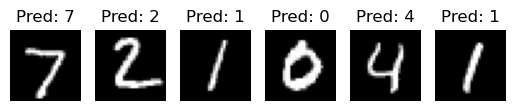

In [12]:
# STEP 6: VISUALIZE A FEW PREDICTIONS

images, labels = next(iter(test_loader))
with torch.no_grad():
    outputs = model(images)
    preds = outputs.argmax(dim=1)

# Plot first 6 predictions
for i in range(6):
    plt.subplot(1, 6, i + 1)
    plt.imshow(images[i][0], cmap="gray")
    plt.title(f"Pred: {preds[i].item()}")
    plt.axis("off")
plt.show()